In [2]:
import re
import pickle
import time 
import json
import joblib
import sqlite3
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm 
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MaxAbsScaler
from xgboost.sklearn import XGBClassifier

from utils import plot_confusion_matrix

%matplotlib inline
plt.style.use('fivethirtyeight')

data_path = Path('/Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/data')
dir_path = Path("/project/arzhetsky/MarketScan_2003_2020/")
report_path = Path('/Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/report')
enrol_intervals_db = "enrol_intervals_days_2020.db"
demographics_db = "demographics_2020.db"
dx_db = "DX_unique_2020.db"

hip_db = "hipFrac.db"

### Functions 

In [2]:
def print_table_name(db_route):
    con = sqlite3.connect(db_route)
    cursor = con.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    print(cursor.fetchall())
    cursor.close()
    con.close()
    return 

def print_column_name(db_route, table_name):
    conn = sqlite3.connect(db_route)
    cursor = conn.cursor()

    # Execute a SQL query to get the column names
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = [column[1] for column in cursor.fetchall()]

    # Print the column names
    print(columns)

    # Close the cursor and the database connection
    cursor.close()
    conn.close()

In [3]:
print_column_name(dir_path / demographics_db, "demographics")

['enrolid', 'sex', 'dobyr']


### Step 1. At Least One year of Continuous Enrollment (N=145054374)


In [12]:
conn = sqlite3.connect(dir_path / enrol_intervals_db)
cursor = conn.cursor()

cursor.execute("SELECT DISTINCT(enrolid), startyear FROM ENROL_INTERVAL WHERE days_in_interval>=365;")
res1 = cursor.fetchall()
cursor.close()
conn.close()

### Step 2. Age >=20 years before or during the enrollment period (N=111287539)

In [ ]:
conn = sqlite3.connect(dir_path / demographics_db)
cursor = conn.cursor()
res2 = []

for idx, (id_, start_year) in enumerate(res1):
    cursor.execute(f"SELECT * FROM demographics WHERE enrolid={id_};")
    demo_info = cursor.fetchall()
    _, sex, dobyr = demo_info[0]
    if (start_year - dobyr >= 20):
        res2.append((id_, start_year, dobyr, sex))
    print(f"{idx / len(res1) * 100: .2f} %", end = "\r")
    
cursor.close()
conn.close()

### Step 3. Diabetes diagnosis on >=2 days of service that are <=2 years apart (N=10984456)

In [ ]:
df = pd.read_csv(data_path / "res3_dict_new.csv")
df = df.reset_index().rename(columns={"index": "enrolid"})

df["Diff_1st_Last"] = df["Last_DM_Day"] - df["First_DM_Day"]

In [ ]:
print(f"Total diabetic patients (>=1 code) in entire MS (2003-2020): {df['enrolid'].nunique()}")
print(f"Total diabetic patients (>=2 code) in entire MS (2003-2020): {df[df['Unique_DM_Visit_Days'] >= 2]['enrolid'].nunique()}")
print(f"Total diabetic patients (>=2 code & 28 or more days apart) in entire MS (2003-2020):  {df[df['Diff_1st_Last'] >= 28]['enrolid'].nunique()}")

Total diabetic patients (>=1 code) in entire MS (2003-2020): 13745416
Total diabetic patients (>=2 code) in entire MS (2003-2020): 10715454
Total diabetic patients (>=2 code & 28 or more days apart) in entire MS (2003-2020):  10001875


In [ ]:

res2_dict = pd.read_pickle(data_path / "res2_dict.pkl")

In [ ]:
df_res2 = pd.DataFrame.from_dict(res2_dict, orient="index", columns=["start_year", "dobyr", "sex"])

In [ ]:
df_res2 = df_res2.reset_index().rename(columns={"index": "enrolid"})

In [ ]:
df_merged = pd.merge(df, df_res2, on = ['enrolid'], how='inner')

In [ ]:
df_merged.head()

,enrolid,Total_DM_Codes,Unique_DM_Visit_Days,First_DM_Day,Second_DM_Day,Last_DM_Day,Min_Diff_bw_Any_Two,Diff_1st_Last,start_year,dobyr,sex
0,101,12,12,51,180,2240,3,2189,2009,1933,2
1,103,10,10,1200,1305,2160,24,960,2006,1933,2
2,302,70,69,1667,2050,6491,0,4824,2018,1934,1
3,501,1,1,3874,3874,3874,0,0,2011,1929,2
4,602,3,3,111,279,419,140,308,2003,1922,1


In [ ]:
df_merged_filtered = df_merged[(df_merged['Unique_DM_Visit_Days'] >= 2) & (df_merged['Diff_1st_Last'] >= 28)]

In [ ]:
df_merged_filtered.to_csv(data_path / "res4_dict.csv", index_label=False)


### Step 4. Diabetes and hip fracture diagnosis

In [ ]:
with open(data_path / "Hip_Fracture_ICD_Codes.txt", "r") as f:
    hip_fracture_icd_codes = []
    for line in f:
        words = line.split()
        icd_code = re.sub(r"\\.(?=[^.])", "", words[0])
        icd_code = icd_code.replace(".", "")
        check = words[-1]
        if check == '1':
            hip_fracture_icd_codes.append(icd_code)

In [ ]:
conn = sqlite3.connect(dir_path / dx_db)
cursor = conn.cursor()

fracture_id = []
patterns = ' OR '.join([f"dx = '{icd}'" for icd in hip_fracture_icd_codes])
query = f"SELECT * FROM DX WHERE ({patterns});"

rows = cursor.execute(query).fetchall()

fracture_icd = set([r[0] for r in rows])

cursor.close()
conn.close()

In [ ]:
df_res4 = pd.read_csv(data_path / "res4_dict.csv")

In [ ]:
fracture_id = list(fracture_icd)
df_res4['Hip_Fracture'] = df_res4['enrolid'].isin(fracture_id).astype('int')

In [ ]:
print(f"Percentage of Hip Fracture and T2D: {df_res4['Hip_Fracture'].sum()} ({df_res4['Hip_Fracture'].mean() * 100:.2f} %)")

Percentage of Hip Fracture and T2D: 120484 (1.20 %)


In [ ]:
df_res4.to_csv(data_path / "res5_dict.csv")

In [ ]:
df_res5 = df_res4.copy()

### Step 5. Disease Bag Signals 

In [6]:
with open(data_path / "dis2code.json", "r") as f:
    dis2code = json.load(f)
    for key in dis2code:
        dis2code[key] = dis2code[key].strip().split(",")

with open(data_path / "Hip_Fracture_ICD_Codes.txt", "r") as f:
    hip_fracture_icd_codes = []
    for line in f:
        words = line.split()
        icd_code = re.sub(r"\\.(?=[^.])", "", words[0])
        icd_code = icd_code.replace(".", "")
        check = words[-1]
        if check == '1':
            hip_fracture_icd_codes.append(icd_code)

In [3]:
df = pd.read_csv(data_path / "HipFracOR_T2D.csv")

In [31]:
df.sort_values(by = "OR", inplace=True)

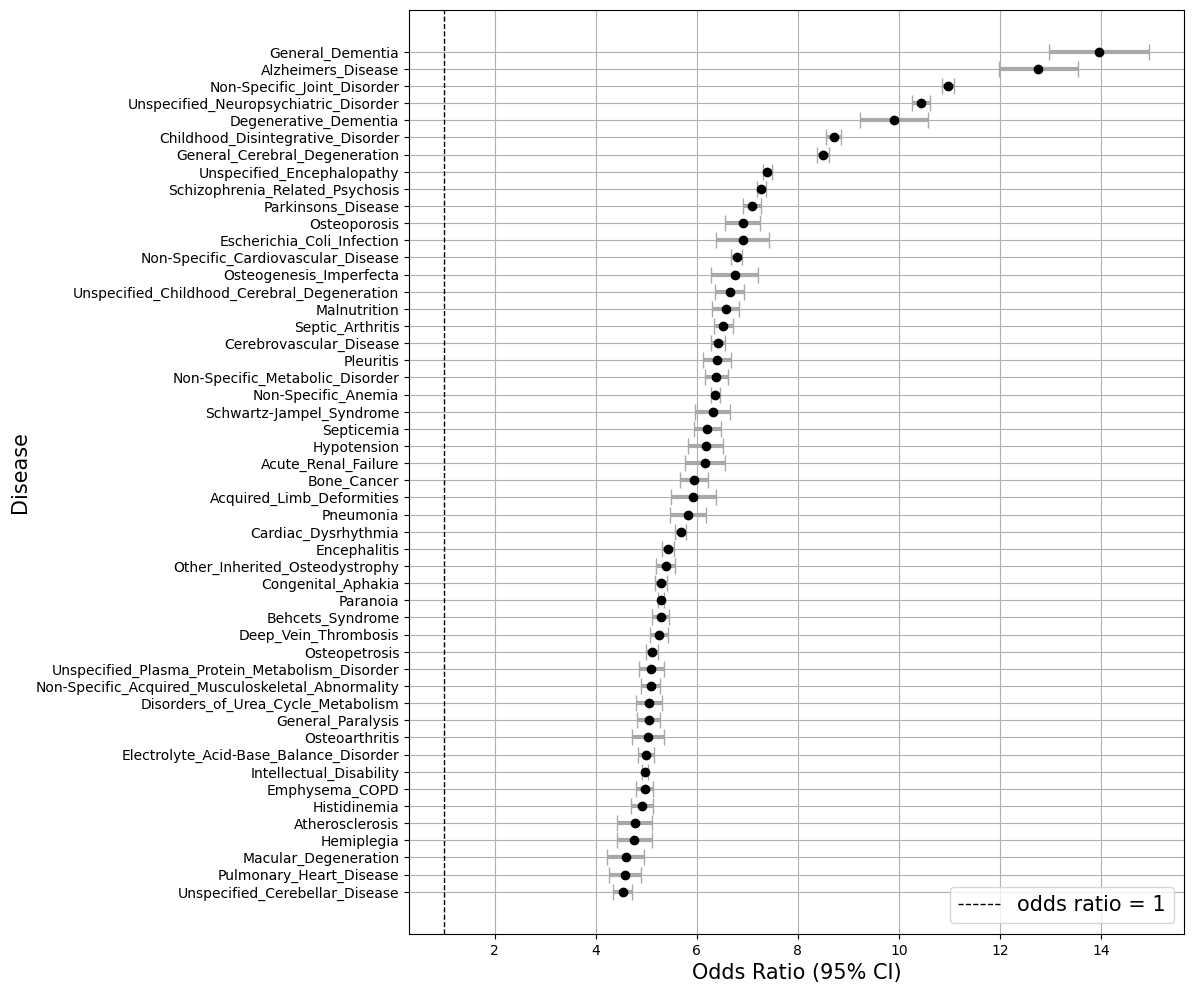

In [37]:
x = df['disease'].tail(50)
y = df['OR'].tail(50)
err = df['OR_ci'].tail(50)

fig, ax = plt.subplots(figsize = (10,12))
ax.errorbar(y, x, xerr=[err, err], fmt='o', color='black',
             ecolor='darkgray', 
             elinewidth=3, 
              capsize=6)

# Set labels and title with custom font size
ax.set_xlabel('Odds Ratio (95% CI)', fontsize=15)
ax.set_ylabel('Disease', fontsize=15)

# Set custom tick label font size for the subplot
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax.axvline(x=1, color='black', linestyle='--', linewidth=1, label = "odds ratio = 1")
ax.legend(loc = "lower right", fontsize = 15)


# Show the plot
plt.grid()
plt.show()


### Step 6. Modeling 

In [3]:
X_train_sparse = sparse.load_npz(data_path / "npz_data/X_train.npz")
y_train_sparse = sparse.load_npz(data_path / "npz_data/y_train.npz")
    
X_test_sparse = sparse.load_npz(data_path / "npz_data/X_test.npz")
y_test_sparse = sparse.load_npz(data_path / "npz_data/y_test.npz")
    
X_train = X_train_sparse.toarray()
del X_train_sparse 

y_train = y_train_sparse.toarray().squeeze()
del y_train_sparse
    
X_test = X_test_sparse.toarray()
del X_test_sparse

y_test = y_test_sparse.toarray().squeeze()
del y_test_sparse
    

In [4]:
features = []
with open(data_path / "features.txt", "r") as f:
    for line in f:
        features.append(line.strip())

model_files = list(report_path.glob('check_point*'))
sgd_models = []
xgb_models = []
for model_file in model_files:
    sgd_model = list(model_file.glob('sgd*'))
    xgb_model = list(model_file.glob('xgb*'))
    if (sgd_model):
        sgd_models.append(sgd_model[0])
    elif (xgb_model):
        xgb_models.append(xgb_model[0])

In [5]:
print(f"percentage of test sample : {y_test.shape[0] * 100 / (y_test.shape[0] + y_train.shape[0]):.2f} %")

percentage of test sample : 33.00 %


#### 6.1. SGD Linear Model

0: model: /Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/report/check_point_2023-03-31-10-48/sgd.pkl, train auc score: 0.81343, test auc score: 0.81363 
1: model: /Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/report/check_point_2023-03-31-11-08/sgd.pkl, train auc score: 0.78794, test auc score: 0.78754 
2: model: /Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/report/check_point_2023-03-30-20-50/sgd.pkl, train auc score: 0.83943, test auc score: 0.84005 
3: model: /Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/report/check_point_2023-03-30-21-04/sgd.pkl, train auc score: 0.78054, test auc score: 0.77915 
4: model: /Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/report/check_point_2023-03-30-15-18/sgd.pkl, train auc score: 0.83423, test auc score: 0.83466 
5: model: /Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/report/check_point_2023-03-30-16-38/sgd.pkl, train auc score: 0.77727, test auc score: 0.77853 
best model: /Users/cj/Documents/LAB/Project/Fracture

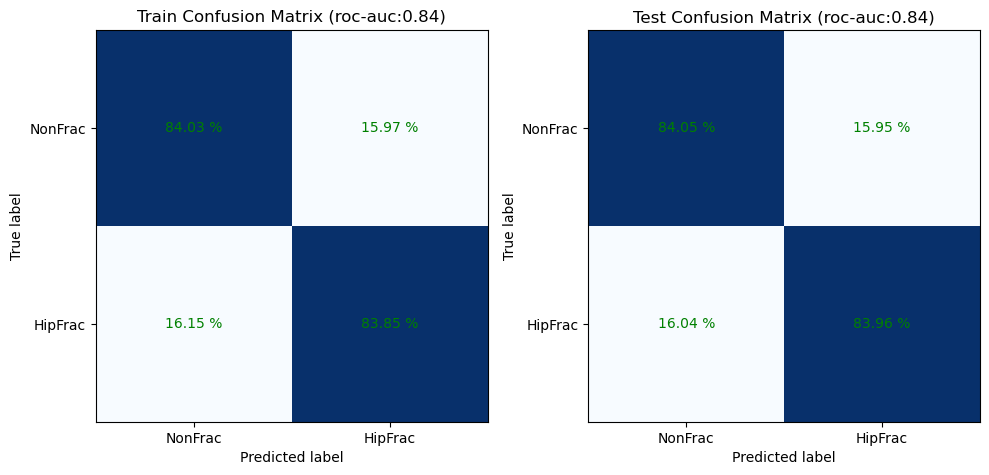

In [13]:
best_auc_score = 0
best_model = None

for idx, model in enumerate(sgd_models):
    clf = joblib.load(model)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    test_auc_score = roc_auc_score(y_test, y_test_pred)
    train_auc_score = roc_auc_score(y_train, y_train_pred)
    if (test_auc_score > best_auc_score):
        best_auc_score = test_auc_score
        best_model = model
        
    print(f"{idx}: model: {sgd_models[idx]}, train auc score: {train_auc_score:.5f}, test auc score: {test_auc_score:.5f} ")

print(f"best model: {best_model}")

clf = joblib.load(best_model)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [14]:
df_sgd_w = pd.DataFrame.from_dict({f: w for f,w in zip(features,clf.coef_[0].tolist())}, orient = "index", columns=['weight'])
df_sgd_w.sort_values(by = "weight", inplace = True, ascending = False)


#### 6.2 XGBoost

In [19]:
best_auc_score = 0
best_model = None

for idx, model in enumerate(xgb_models):
    clf = XGBClassifier()
    clf.load_model(model)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    test_auc_score = roc_auc_score(y_test, y_test_pred)
    train_auc_score = roc_auc_score(y_train, y_train_pred)
    if (test_auc_score > best_auc_score):
        best_auc_score = test_auc_score
        best_model = model
        
    print(f"{idx}: model: {xgb_models[idx]}, train auc score: {train_auc_score:.5f}, test auc score: {test_auc_score:.5f} ")
    
print(f"best model: {best_model}")

0: model: /Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/report/check_point_2023-04-07-13-24/xgb.json, train auc score: 0.86830, test auc score: 0.85204 
1: model: /Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/report/check_point_2023-04-07-14-05/xgb.json, train auc score: 0.86830, test auc score: 0.85204 
2: model: /Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/report/check_point_2023-04-07-12-59/xgb.json, train auc score: 0.86830, test auc score: 0.85204 
3: model: /Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/report/check_point_2023-04-07-11-46/xgb.json, train auc score: 0.86830, test auc score: 0.85204 
4: model: /Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/report/check_point_2023-03-31-16-25/xgb.json, train auc score: 0.79808, test auc score: 0.70305 
best model: /Users/cj/Documents/LAB/Project/Fracture/HipFracT2D/report/check_point_2023-04-07-13-24/xgb.json


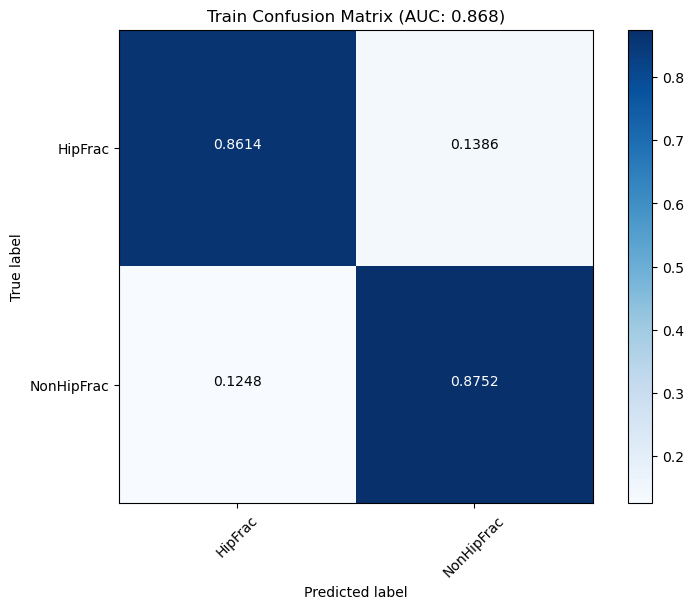

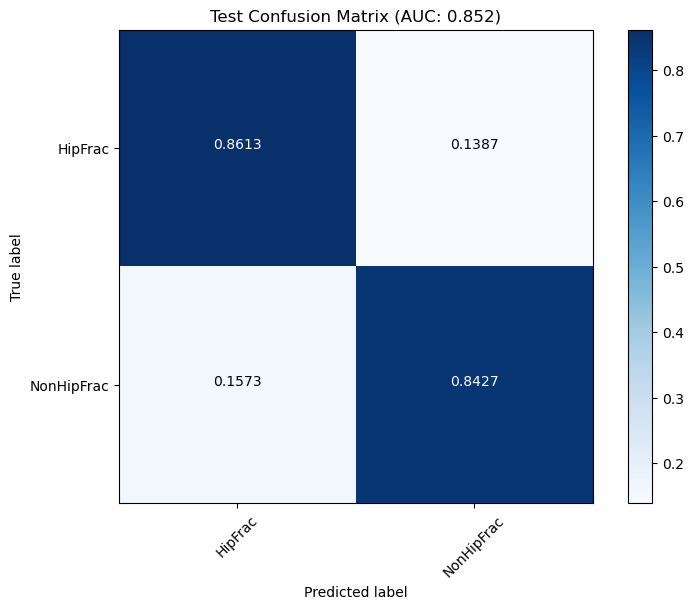

In [15]:
clf.load_model(best_model)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

plot_confusion_matrix(y_train, y_train_pred, target_names = ['HipFrac', 'NonHipFrac'], title = "Train Confusion Matrix (AUC: 0.868)")
plot_confusion_matrix(y_test, y_test_pred, target_names = ['HipFrac', 'NonHipFrac'], title = "Test Confusion Matrix (AUC: 0.852)")


In [25]:
def swap(x, y, features):
    idx1 = features.index(x)
    idx2 = features.index(y)
    features[idx1] = y
    features[idx2] = x
    return

In [75]:
swap('Non-Specific_Joint_Disorder', 'Schwartz-Jampel_Syndrome', features)

In [76]:
df_xgb_w = pd.DataFrame.from_dict({f: w for f,w in zip(features,clf.feature_importances_)}, orient = "index", columns=['weight'])
df_xgb_w.sort_values(by = "weight", inplace = True, ascending = False)

In [77]:
df_xgb_w.to_csv(data_path / "xgboost_weight.csv")

In [78]:
df_xgb_w

,weight
Schwartz-Jampel_Syndrome,0.061788
Osteogenesis_Imperfecta,0.027003
Multiple_Epiphyseal_Dysplasia,0.018911
General_Dementia,0.018601
Osteoporosis,0.015442
...,...
Ellis_Van_Creveld_Syndrome,0.000000
Paritial_Androgen_Insensitivity_Syndrome,0.000000
Glucocorticoid-Remediable_Aldosteronism,0.000000
Peroxisomal_Disorders,0.000000


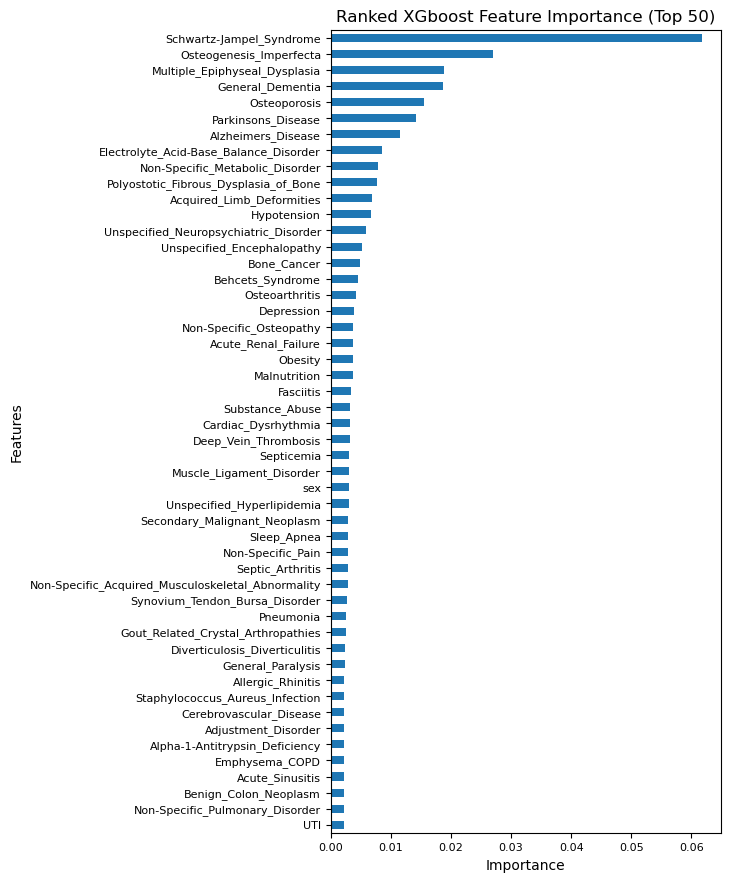

In [79]:
# y_labels = df_xgb_w.index.tolist[:50]
# x_values = df_xgb_w.weight.tolist[:50]
df_xgb_w.sort_values(by = "weight", ascending=True, inplace = True)

fig, ax = plt.subplots(figsize=(6, 11))
df_xgb_w.iloc[-50:].plot.barh(y='weight', ax=ax, legend=False)

# Set plot title and axis labels
ax.set_title('Ranked XGboost Feature Importance (Top 50)')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')

# Set tick label size
ax.tick_params(axis='both', which='major', labelsize=8)

# Set axis limits and ticks
# ax.set_xlim([0, 35])
# ax.set_xticks([0, 10, 20, 30])

# Remove top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# Adjust plot margins
plt.subplots_adjust(left=0.25, bottom=0.15)

### Step 7. Time sequence on HipFrac | T2D

Text(0, 0.5, 'Density')

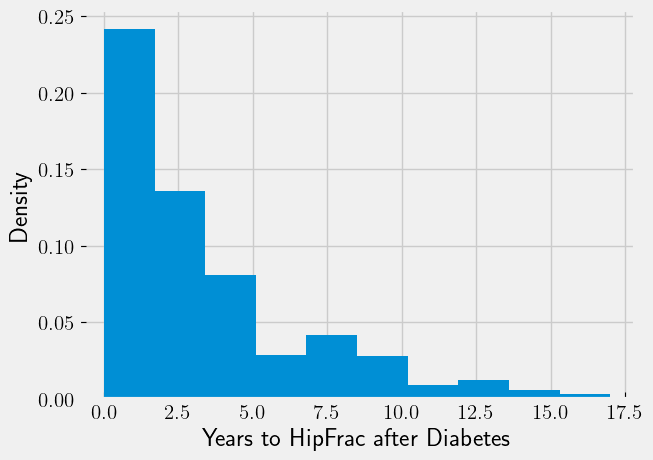

In [6]:
df = pd.read_csv(data_path / "time_decay_df.csv")

fsize = 15
tsize = 18

tdir = 'in'

major = 5.0
minor = 3.0

plt.figure()

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

_ = plt.hist(df['delta_y'], bins=10,density=True)
plt.xlabel("Years to HipFrac after Diabetes")
plt.ylabel("Density")


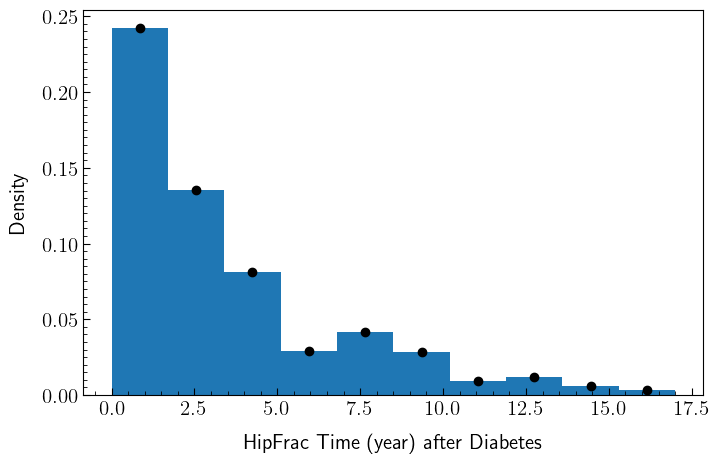

In [15]:
from matplotlib.ticker import MultipleLocator

fsize = 15
tsize = 18

tdir = 'in'

major = 5.0
minor = 3.0

style = 'default'

plt.style.use(style)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

r = 15
theta = 5
rw = 12
gamma = 0.1

xsize = 8
ysize = 5

#fig, ax = plt.subplots(figsize=(xsize, ysize))

plt.figure(figsize=(xsize, ysize))

    
n, x, _ = plt.hist(df['delta_y'], bins=10,density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.scatter(bin_centers,n,c="black")

ax = plt.gca()

ax.xaxis.set_minor_locator(MultipleLocator(.5))
ax.yaxis.set_minor_locator(MultipleLocator(.005))

plt.xlabel('HipFrac Time (year) after Diabetes', labelpad = 10)
plt.ylabel('Density', labelpad = 10);
plt.savefig('professional_plot.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')